In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [2]:
import webbrowser
import os.path as os
from __future__ import print_function
from itertools import combinations

In [8]:
df = pd.read_excel("./latLngDataset.xlsx")
df.head(5)

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Delhi,28.6600,77.2300,India,IN,Delhi,admin,29617000.0,16753235.0
1,Mumbai,18.9667,72.8333,India,IN,Mahārāshtra,admin,23355000.0,12478447.0
2,Kolkāta,22.5411,88.3378,India,IN,West Bengal,admin,17560000.0,4496694.0
3,Bangalore,12.9699,77.5980,India,IN,Karnātaka,admin,13707000.0,8443675.0
4,Chennai,13.0825,80.2750,India,IN,Tamil Nādu,admin,11324000.0,6727000.0


In [ ]:
a1 = df["lat"]
a1.to_frame()

,lat
0,28.6600
1,18.9667
2,22.5411
3,12.9699
4,13.0825
...,...
182,15.4800
183,20.4170
184,10.5626
185,30.6915


In [9]:
a2 = df["lng"]
a2.to_frame()

,lng
0,77.2300
1,72.8333
2,88.3378
3,77.5980
4,80.2750
...,...
182,73.8300
183,72.8500
184,72.6369
185,76.8537


In [10]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [ ]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [11]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [12]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [13]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [ ]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [14]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [ ]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [15]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [16]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [17]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [18]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [19]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute



In [ ]:
# cityList = []

# for i in range(0,25):
#     cityList.append(City(a1, a2))

cityList = []

for i in range(0,25):
    cityList.append(City(a1[i],a2[i]))

In [ ]:
cityList

[(28.66,77.23),
 (18.9667,72.8333),
 (22.5411,88.3378),
 (12.9699,77.598),
 (13.0825,80.275),
 (17.3667,78.4667),
 (18.5196,73.8553),
 (23.03,72.58),
 (21.17,72.83),
 (26.847,80.947),
 (26.9167,75.8667),
 (26.4725,80.3311),
 (25.15,82.58),
 (21.1539,79.0831),
 (28.6667,77.4167),
 (22.7206,75.8472),
 (22.3,73.2),
 (17.7333,83.3167),
 (23.25,77.4167),
 (18.6278,73.8131),
 (25.61,85.1414),
 (30.9083,75.8486),
 (27.18,78.02),
 (19.2502,73.1602),
 (9.9197,78.1194)]

In [ ]:
distValue = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 171.40718658700618
Final distance: 69.27178999123215


In [ ]:
distValue

[(-14.270972,-170.132217),
 (-38.416097,-63.616671999999994),
 (-75.250973,-0.071389),
 (-11.202691999999999,17.873887),
 (-3.3730559999999996,29.918885999999997),
 (-25.274398,133.775136),
 (23.684994,90.35633100000001),
 (33.93911,67.709953),
 (23.424076,53.847818000000004),
 (25.930414000000003,50.637772),
 (40.143105,47.576927000000005),
 (40.069099,45.038189),
 (42.733883,25.48583),
 (41.153332,20.168331),
 (43.915886,17.679076000000002),
 (47.516231,14.550072),
 (50.503887,4.469936),
 (42.546245,1.6015540000000001),
 (9.30769,2.315834),
 (12.238333,-1.561593),
 (18.220554,-63.068615),
 (17.060816,-61.796428000000006),
 (13.193887,-59.543198),
 (12.226078999999999,-69.060087),
 (12.52111,-69.968338)]

In [ ]:
type(distValue)


list

In [ ]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

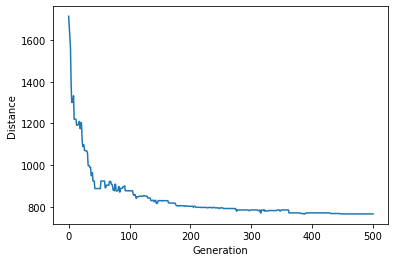

In [ ]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)